<a href="https://colab.research.google.com/github/WaterPurify/Alpaco_Bootcamp/blob/main/3_Computer%20Vision%20Classification/Group_Project/Artists_classification_version1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Artists Classification

* 데이터는 kaggle에 있는 Best Artworks of ALL Time 사용하였습니다.

* 유명한 50명의 화가를 분류할 수 있었지만 비교적 오래된 모델인 InceptionV3 (2015) 모델을 적용하여서 성능의 한계가 있다고 판단하였습니다 (정확도 67%). 따라서 성능,정확도와 속도,를 높일 수 있는 방법을 적용해 보았습니다.

* 성능 향상 방법
    1. ViT (Vision Transformer)를 transfer learning을 적용
    2. TrivialAugmentWide를 적용
    3. LoRA (Low-Rank Adaptation of Large Language Models) fine-tuning 진행
  


## 데이터
* Best Artworks of All Time
    - https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time
* 구조

 1. artists.csv
   *  각 화가의 정보 dataset
 2. images.zip
   *  원본 이미지들
 3. resized.zip
   *  256x256 사이즈로 resize된 이미지들



In [1]:
# Local로 다운로드하여 dataset을 unzip
!unzip -q "/content/drive/MyDrive/Colab Notebooks/images (1).zip" -d "/content/drive/MyDrive"


unzip:  cannot find or open /content/drive/MyDrive/Colab Notebooks/images (1).zip, /content/drive/MyDrive/Colab Notebooks/images (1).zip.zip or /content/drive/MyDrive/Colab Notebooks/images (1).zip.ZIP.


In [ ]:
# 필요한 라이브러리 및 버전 확인

from __future__ import print_function
from __future__ import division

# System
import sys
import os #
import argparse
import copy #


# Time
import time #
import datetime

# Numerical Data
import random
import numpy as np #
import pandas as pd

# Tools
import collections
import shutil
from glob import glob
from tqdm import tqdm
import gc

# NLP
import re

# Preprocessing
from sklearn import preprocessing
from sklearn.utils import class_weight as cw
from sklearn.utils import shuffle

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Machine Learning Models
from sklearn import svm
from sklearn.svm import LinearSVC, SVC

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score


# Deep Learning -  -  Preprocessing

# Deep Learning -  - Model
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms

# Deep Learning -  - Layers

from keras.regularizers import l2

# Deep Learning -  - Pretrained Models

# Deep Learning - Keras - Model Parameters and Evaluation Metrics
import torch.optim as optim

# Deep Learning -  - Visualisation

# Deep Learning - TensorFlow
# import tensorflow as tf

# Graph/ Visualization
import matplotlib.pyplot as plt #
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# Image
import cv2
from PIL import Image
from IPython.display import display

# np.random.seed(42)

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

# Input data
print(os.listdir("/content/drive/MyDrive/images"))

%matplotlib inline

PyTorch Version:  2.2.1+cu121
Torchvision Version:  0.17.1+cu121


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/images'

In [ ]:
# 입력 directory와 출력 directory 설정

data_dir = "/content/drive/MyDrive/images"

input_directory = r"/content/drive/MyDrive/images"
output_directory = r"../output/"

# 학습와 test할 수 있는 directory 생성
# training_dir = input_directory + "images/images"
training_dir = data_dir
# testing_dir = input_directory + r"images/images"
testing_dir = data_dir

# 만약에 출력 directory가 존재하지 않으면 만들어줌
if not os.path.exists(output_directory):
    os.mkdir(output_directory)

figure_directory = "../output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)


file_name_pred_batch = figure_directory + r"/result"
file_name_pred_sample = figure_directory + r"/sample"

In [ ]:
# 50 화가이름
i = 1
for dir in (os.listdir(data_dir)):
    print(" {}. {}".format(i, dir))
    i = i + 1

 1. Amedeo_Modigliani
 2. Vasiliy_Kandinskiy
 3. Diego_Rivera
 4. Claude_Monet
 5. Rene_Magritte
 6. Salvador_Dali
 7. Edouard_Manet
 8. Andrei_Rublev
 9. Vincent_van_Gogh
 10. Gustav_Klimt
 11. Hieronymus_Bosch
 12. Kazimir_Malevich
 13. Peter_Paul_Rubens
 14. Pierre-Auguste_Renoir
 15. Francisco_Goya
 16. Frida_Kahlo
 17. El_Greco
 18. Albrecht_Dürer
 19. Alfred_Sisley
 20. Pieter_Bruegel
 21. Giotto_di_Bondone
 22. Sandro_Botticelli
 23. Caravaggio
 24. Diego_Velazquez
 25. Henri_Matisse
 26. Jan_van_Eyck
 27. Edgar_Degas
 28. Rembrandt
 29. Titian
 30. Henri_de_Toulouse-Lautrec
 31. Gustave_Courbet
 32. Camille_Pissarro
 33. William_Turner
 34. Edvard_Munch
 35. Eugene_Delacroix
 36. Henri_Rousseau
 37. Georges_Seurat
 38. Paul_Klee
 39. Piet_Mondrian
 40. Joan_Miro
 41. Andy_Warhol
 42. Raphael
 43. Jackson_Pollock
 44. Leonardo_da_Vinci
 45. Marc_Chagall
 46. Michelangelo
 47. Mikhail_Vrubel
 48. Pablo_Picasso
 49. Paul_Cezanne
 50. Paul_Gauguin


In [ ]:
# 데이터 프레임으로 만들어줌
label_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/artists.csv")
# label_df.head()
label_df.summary()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194
5,5,Salvador Dali,1904 - 1989,Surrealism,Spanish,Salvador Domingo Felipe Jacinto Dalí i Domènec...,http://en.wikipedia.org/wiki/Salvador_Dalí,139
6,6,Edouard Manet,1832 - 1883,"Realism,Impressionism",French,Édouard Manet (US: ; UK: ; French: [edwaʁ manɛ...,http://en.wikipedia.org/wiki/Édouard_Manet,90
7,7,Andrei Rublev,1360 - 1430,Byzantine Art,Russian,"Andrei Rublev (Russian: Андре́й Рублёв, IPA: [...",http://en.wikipedia.org/wiki/Andrei_Rublev,99
8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
9,9,Gustav Klimt,1862 - 1918,"Symbolism,Art Nouveau",Austrian,"Gustav Klimt (July 14, 1862 – February 6, 1918...",http://en.wikipedia.org/wiki/Gustav_Klimt,117


[]

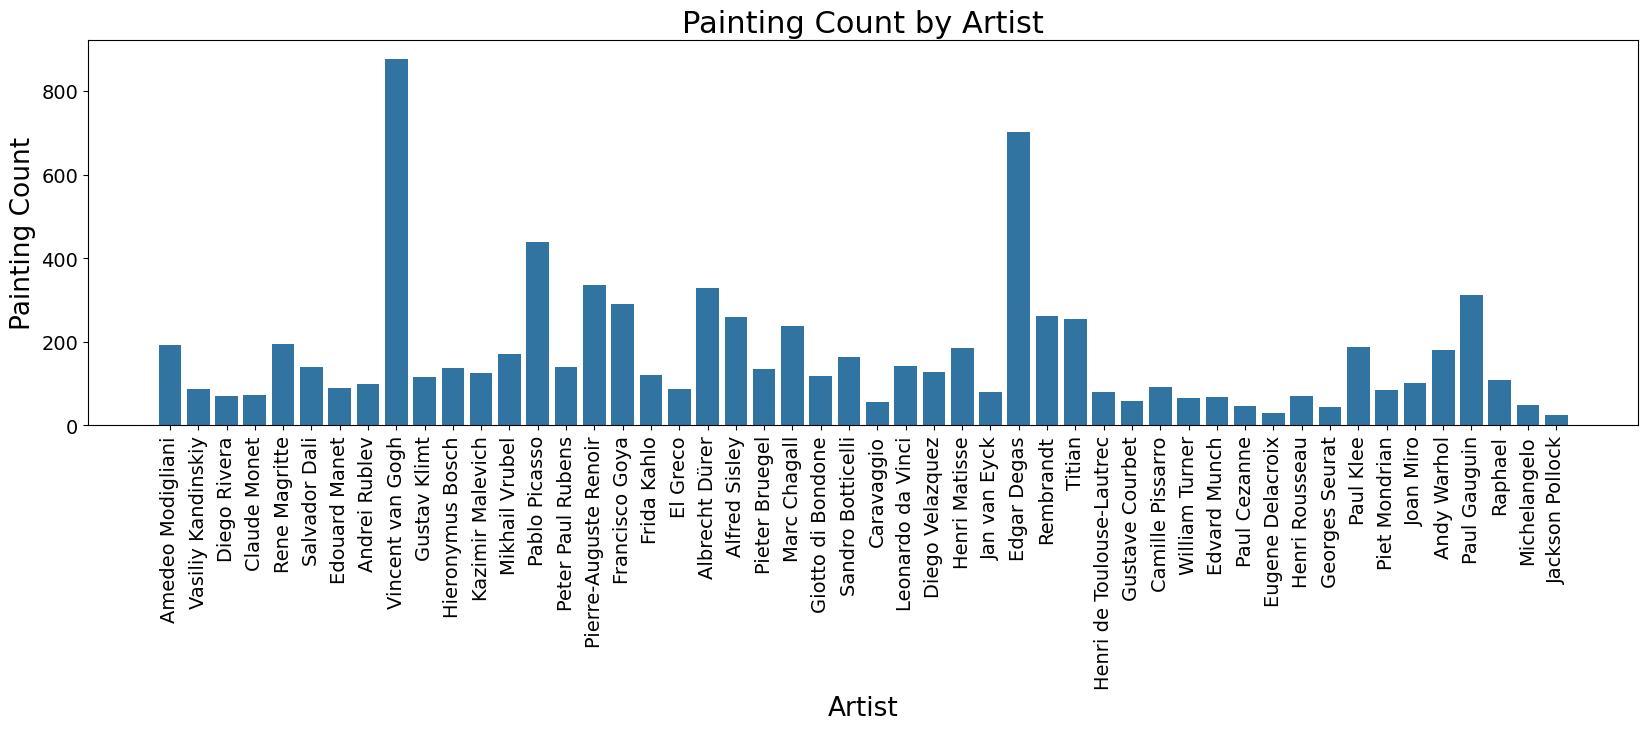

In [ ]:
# 각각의 화가 작품들 시각화
df = label_df

figsize=(20, 5)

ticksize = 14
titlesize = ticksize + 8
labelsize = ticksize + 5

xlabel = "Artist"
ylabel = "Painting Count"

title = "Painting Count by Artist"


params = {'figure.figsize' : figsize,
          'axes.labelsize' : labelsize,
          'axes.titlesize' : titlesize,
          'xtick.labelsize': ticksize,
          'ytick.labelsize': ticksize}

plt.rcParams.update(params)

col1 = "name"
col2 = "paintings"

sns.barplot(x=col1, y=col2, data=df)
plt.title(title)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xticks(rotation=90)
plt.plot()

## 데이터의 불균형 문제

* 위의 그래프에서 보이는 것처럼 Vicent Van Gogh와 Edgar Degas화가의 작품이 800개 이상으로 다른 화가 작품들 보다 압도적으로 많습니다.

* 문제를 해결하기 위해서 TrivialAugmentWide 사용하였습니다.

In [ ]:
#다양한 CNN를 바탕으로 하는 모델을 설정할 수 있는 코드입니다.

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
# model_name = "resnet"
# model_name = "vgg"
# model_name = "densenet"
model_name = "inception"

# Number of classes
num_classes = len(os.listdir(data_dir))

# Batch size for training
batch_size = 32
# batch_size = 192

# Number of epochs
num_epochs = 15

# feature_extract을 True로 설정하여 Transfer learning을 할 수 있도록 우리 dataset에 적용 가능
# 만약 false이면 학습을 처음부터 다시 해야 됩니다.
feature_extract = True

In [ ]:
# 학습할 수 있는 함수 생성

def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    # 가장 좋은 weight를 저장합니다
    # 최고의 정확도를 갱신합니다
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 학습이랑 validation에 따라 epoch를 돌아줍니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # 오차랑 맞은 개수를 갱신합니다

            running_loss = 0.0
            running_corrects = 0

            # 입력 데이터에 대하여 iterable하게 적용
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)


                # Batch 마다 그전 gradient의 영향을 받지 않기 위해서 zero_grad 사용합니다
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# ViT 모델 모델 적용하는 함수

def create_vit_model(num_classes:int=10,
                     seed:int=42,
                     is_TrivialAugmentWide = True,
                     freeze_layers=True
                     ):
    """Creates a ViT_B16 feature extractor model and transforms.
    Args:
        num_classes (int): number of target classes, default = 10.
        seed (int, optional): random seed value for output layer, default = 42.
        is_TrivialAugmentWide (boolean): Artificially increase the diversity of a training dataset with data augmentation, default = True.
        freeze_layers (boolean): freeze all layers in model, default = True.
    Returns:
        vit_b16_model (torch.nn.Module): ViT_B16 feature extractor model.
        vit_b16_transforms (torchvision.transforms): ViT_B16 image transforms.
    """
    # Create ViT_B_16 pretrained weights and transforms
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    vit_b16_transforms = weights.transforms()
    # add data augmentation
    if is_TrivialAugmentWide:
      vit_b16_transforms = torchvision.transforms.Compose([
          torchvision.transforms.TrivialAugmentWide(),
          vit_b16_transforms,
      ])
    # create the VIT_B16 model
    vit_b16_model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in the model
    if freeze_layers:
        for param in vit_b16_model.parameters():
            param.requires_grad = False

    # Change classifier head to reflect target number of classes
    torch.manual_seed(seed)
    vit_b16_model.heads = nn.Sequential(nn.Linear(in_features=768,
                                                  out_features=num_classes))

    return vit_b16_model, vit_b16_transforms

In [ ]:
# 서로 다른 모델 transfer learning을 위한 함수


def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    elif model_name =='ViT':

        # vit_b16_model, vit_b16_transforms=create_vit_model(num_classes:int=10,
        #              seed:int=42,
        #              is_TrivialAugmentWide = True,
        #              freeze_layers=True
        #              )
        # model_ft =vit_b16_model
        # input_size = 256

        model_name = "google/vit-base-patch16-224"
        model = ViTForImageClassification.from_pretrained(model_name)
        model.head = nn.Linear(in_features =768,out_features=num_classes,bias=True)
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [ ]:
# 모델 초기화
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
# print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 92.2MB/s] 


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
# Trivail augmentation Wide 방식을 적용
# data_transforms = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }

data_transforms ={
    'train':  transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.TrivialAugmentWide(num_magnitude_bins=8), # Data Augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
  'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(data_dir, data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# # Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
image_datasets

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'train': Dataset ImageFolder
     Number of datapoints: 8446
     Root location: /content/drive/MyDrive/images
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(299, 299), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 8446
     Root location: /content/drive/MyDrive/images
     StandardTransform
 Transform: Compose(
                Resize(size=299, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(299, 299))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [ ]:
# Data loading code
# traindir = "../input/images/images"
traindir = data_dir

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset = datasets.ImageFolder(
    traindir,
    transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ]))

train_sampler = None


train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=(train_sampler is None),
    num_workers=4, pin_memory=True, sampler=train_sampler)

In [ ]:
train_loader

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
# optimizer_ft = optim.Adam(params_to_update, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsgrad=False)
optimizer_ft = optim.Adam(params_to_update, lr=1e-3)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [ ]:
# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 3.9739 Acc: 0.2533
val Loss: 2.2721 Acc: 0.4324

Epoch 1/14
----------
train Loss: 2.9902 Acc: 0.3995
val Loss: 1.8632 Acc: 0.5229

Epoch 2/14
----------
train Loss: 2.7068 Acc: 0.4394
val Loss: 1.6658 Acc: 0.5562

Epoch 3/14
----------
train Loss: 2.5413 Acc: 0.4651
val Loss: 1.5377 Acc: 0.5858

Epoch 4/14
----------
